In [1]:
from collections import OrderedDict
from glob import glob
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os
from itertools import product

In [2]:
log_root = '../logs/'

In [10]:
lrG = 0.0001
lrD = 0.0003
data = 'mnist'

exp_names = {
    f'{data}/Adam/alexgda_gamma0.0_delta1.0_G0.0003_D0.0001': 'Sim-Adam\n(G3e-4,D1e-4)',
    f'{data}/Adam/altgda_gamma1.0_delta1.0_G0.0003_D0.0001': 'Alt-Adam\n(G3e-4,D1e-4)',
    f'{data}/Adam/alexgda_gamma1.0_delta4.0_G0.0003_D0.0001': 'Alex-Adam\n($\gamma=1,\delta=4$)\n(G3e-4,D1e-4)',
    # f'{data}/Adam/alexgda_gamma2.0_delta4.0_G0.0003_D0.0001': 'Alex-Adam\n($\gamma=2,\delta=4$)\n(G3e-4,D1e-4)',
}

In [11]:
# lrG = 0.0003
# lrD = 0.0001
# data = 'mnist'

# exp_names = {
#     f'{data}/Adam/simgda_gamma0.0_delta1.0_G{lrG}_D{lrD}': 'Sim-GDA',
#     f'{data}/Adam/altgda_gamma1.0_delta1.0_G{lrG}_D{lrD}': 'Alt-GDA',
# }
# # exp_names.update({
# #     f'{data}/Adam/altgda_gamma1.0_delta1.0_G{lrG}_D{lrD}': f'Alt-GDA_G{lrG}_D{lrD}' for lrG, lrD in product([1e-4, 3e-4], repeat=2)
# # })
# for gamma, delta in product([1, 0, 1.2, 1.5, 2, 4], [1, 1.2, 1.5, 2, 4]):
#     exp_names[
#         f'{data}/Adam/alexgda_gamma{float(gamma)}_delta{float(delta)}_G{lrG}_D{lrD}'
#     ] = f'Alex-GDA($\gamma={gamma},\delta={delta}$)'

In [12]:
scores_dict = {dir: [] for dir in exp_names}
for dir in exp_names:
    for i, path in enumerate(sorted(glob(os.path.join(log_root, dir, '*')))):
        filename = os.path.join(path, 'FID.json')
        if not os.path.exists(filename): continue
        with open(filename) as f:
            scores_list = json.load(f)
        scores_dict[dir].append(scores_list[-1])
scores_dict = OrderedDict(reversed([(dir, np.array(sorted(scores_list))) for dir, scores_list in scores_dict.items() if len(scores_list)>0]))
scores_dict

OrderedDict([('mnist/Adam/alexgda_gamma1.0_delta4.0_G0.0003_D0.0001',
              array([1.2709996 , 1.45427879, 1.47942621, 1.66868941, 2.25395579])),
             ('mnist/Adam/altgda_gamma1.0_delta1.0_G0.0003_D0.0001',
              array([1.46510906, 1.55755118, 1.66281991, 1.69876921, 1.85693124,
                     1.93068092, 1.93927785, 2.02252041, 2.27244851, 2.45080093])),
             ('mnist/Adam/alexgda_gamma0.0_delta1.0_G0.0003_D0.0001',
              array([2.83723462, 2.90907281, 3.48549738, 5.51613076, 5.79105313]))])

In [13]:
scores_means = [stats.trim_mean(scores, .25) for scores in scores_dict.values()]
# scores_means = [np.mean(scores) for scores in scores_dict.values()]
scores_stds = [np.std(scores) for scores in scores_dict.values()]
scores_errs = np.array([[mean-np.min(scores),np.max(scores)-mean] for scores, mean in zip(scores_dict.values(), scores_means)]).T
names = [exp_names[k] for k in scores_dict]
scores_means, scores_errs

([1.5341314727488964, 1.8518332580814416, 3.9702336479053884],
 array([[0.26313187, 0.3867242 , 1.13299903],
        [0.71982432, 0.59896767, 1.82081948]]))

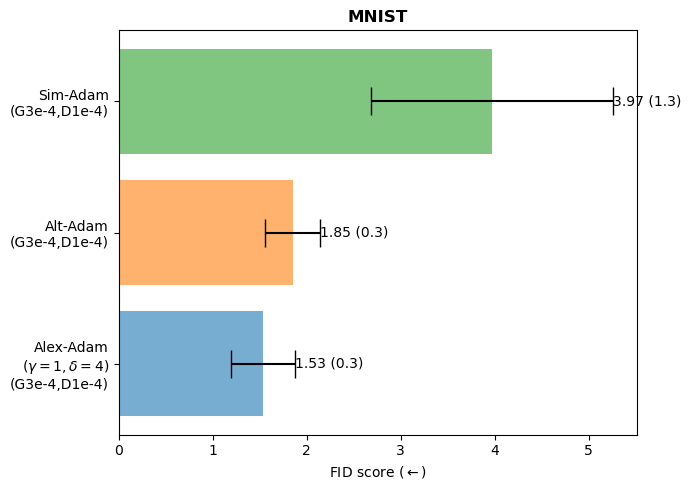

In [14]:
fig, axes = plt.subplots(1,1, figsize=(7,5))
ax = axes
bar = ax.barh(names, scores_means, xerr=scores_stds, capsize=10, alpha=0.6, color=[c['color'] for c in plt.cycler(color=plt.cm.tab10.colors)])
means = map(lambda x: round(x,2), scores_means)
stds = map(lambda x: round(x,1), scores_stds)
ax.bar_label(bar, map(lambda x: f"{x[0]} ({x[1]})", zip(means, stds)))
# ax.set_xlim(2, 8)
ax.set_xlabel('FID score ($\leftarrow$)')
ax.set_title("MNIST", weight='bold')
fig.tight_layout()
fig.savefig('vis_mnist.pdf')

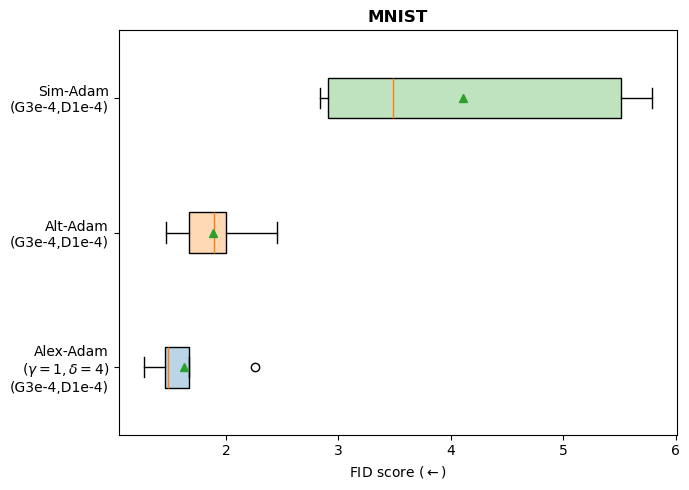

In [15]:
fig, axes = plt.subplots(1,1, figsize=(7,5))
ax = axes
bp = ax.boxplot(scores_dict.values(), vert=False, labels=names, showmeans=True, patch_artist=True)
for patch, color in zip(bp['boxes'], [c['color'] for c in plt.cycler(color=plt.cm.tab10.colors)]*10):
    patch.set_facecolor(color + (0.3,))
ax.set_xlabel('FID score ($\leftarrow$)')
ax.set_title("MNIST", weight='bold')
fig.tight_layout()
fig.savefig('vis_mnist_2.pdf')